# Проект: вариант 1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.

2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.

3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

## Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

- shared/problem1-reg_data.csv – данные о времени регистрации
- shared/problem1-auth_data.csv – данные о времени захода пользователей в игру

In [2]:
import pandas as pd
import numpy as np
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import bootstrap
from scipy.stats import chisquare
from scipy.stats import chi2_contingency

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-r-gilvanov/shared/problem1-reg_data.csv', sep=';')
reg_data.head()

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [3]:
auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-r-gilvanov/shared/problem1-auth_data.csv', sep=';')
auth_data.head()

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [4]:
#Знакомство с нашими данными: кол-во строк и столбцов, типы переменных, а так же наличие пропущенных значений

reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [5]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [6]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [7]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [8]:
# Преобразование временной метки в читаемый формат
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s')
reg_data.head()

,reg_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5


In [9]:
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s')
auth_data.head()

,auth_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,1999-07-25 16:46:46,2
3,1999-07-31 03:50:15,2
4,1999-08-05 17:49:39,2


In [10]:
# Оставим в датах только день, когда было совершено действие
reg_data['reg_ts'] = reg_data['reg_ts'].dt.date
auth_data['auth_ts'] = auth_data['auth_ts'].dt.date

In [11]:
# Проанализируем минимальную и максимальную дату в наших данных

reg_data['reg_ts'].agg(['min', 'max'])

min    1998-11-18
max    2020-09-23
Name: reg_ts, dtype: object

In [12]:
auth_data['auth_ts'].agg(['min', 'max'])

min    1998-11-18
max    2020-09-23
Name: auth_ts, dtype: object

In [13]:
# Объединим данные с авторизациями и регистрациями по 'uid'

merged_df = pd.merge(auth_data, reg_data, on='uid', how='inner')

In [14]:
merged_df

,auth_ts,uid,reg_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-25,2,1999-07-22
3,1999-07-31,2,1999-07-22
4,1999-08-05,2,1999-07-22
...,...,...,...
9601008,2020-09-23,1110618,2020-09-23
9601009,2020-09-23,1110619,2020-09-23
9601010,2020-09-23,1110620,2020-09-23
9601011,2020-09-23,1110621,2020-09-23


In [35]:
def retention_rate(merged_df, start_time, finish_time, max_days=None):
    
    """
    Функция для вычисления коэффициента удержания (retention) по когортам с последующей визуализацией.

    Параметры:
    merged_df: объединенный DataFrame, содержащий данные о регистрациях и авторизациях пользователей.
    start_time: дата начала периода в формате 'YYYY-MM-DD'.
    finish_time: дата окончания периода в формате 'YYYY-MM-DD'.
    max_days: количество дней, отображаемых в результате вычисления удержания пользователей.
    
    Возвращает: DataFrame с рассчитанным коэффициентом удержания за указанный период.
    """
    
    # Преобразование строковых дат в datetime
    start_time = pd.to_datetime(start_time)
    finish_time = pd.to_datetime(finish_time)
    
    # Фильтрация данных по времени
    filtered_df = merged_df[(merged_df['reg_ts'] >= start_time) & (merged_df['reg_ts'] <= finish_time)]
    
    # Проверка, есть ли данные после фильтрации
    if filtered_df.empty:
        print("Нет данных в заданном диапазоне дат.")
        return None
    
    # Создаем вспомогательный DataFrame для подсчета когорт по дням
    cohort_data = filtered_df.groupby(['reg_ts', 'auth_ts']).agg({'uid': 'nunique'}).reset_index()
    
    # Вычисляем номер дня от регистрации
    cohort_data['day_number'] = (cohort_data['auth_ts'] - cohort_data['reg_ts']).dt.days
    
    # Сводим данные для отображения
    cohort_pivot = cohort_data.pivot_table(index='reg_ts', columns='day_number', values='uid', fill_value=0)
    
    # Заменяем значения 0 на NaN
    cohort_pivot.replace(0, np.nan, inplace=True)
    
    # Определяем количество пользователей в каждой когорте
    cohort_sizes = cohort_pivot.iloc[:, 0]
    
    # Вычисляем удержание
    retention = (cohort_pivot.divide(cohort_sizes, axis=0))
    
    # Удаляем нулевой день (столбец с day_number = 0)
    retention = retention.drop(columns=[0], errors='ignore')
    
    # Ограничиваем количество выводимых дней, если max_days задан
    if max_days is not None:
        retention = retention.iloc[:, :max_days]

    # Визуализация 
    ur_style = (retention
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
    
    return ur_style  # Возвращаем результат

In [19]:
retention_rate(merged_df, '2020-09-10', '2020-09-23', max_days=15)

day_number,1,2,3,4,5,6,7,8,9,10,11,12,13
reg_ts,,,,,,,,,,,,,
2020-09-10,2.05%,4.29%,4.79%,4.23%,6.77%,6.28%,7.09%,4.85%,4.54%,5.66%,4.72%,5.22%,3.60%
2020-09-11,1.30%,4.03%,4.53%,5.65%,5.71%,6.70%,6.33%,4.40%,4.65%,5.40%,5.33%,3.29%,
2020-09-12,1.92%,3.84%,4.71%,4.65%,6.07%,6.57%,5.76%,5.27%,5.14%,5.70%,2.54%,,
2020-09-13,1.98%,4.08%,4.26%,5.13%,6.55%,6.49%,4.94%,4.70%,4.94%,3.58%,,,
2020-09-14,2.22%,3.83%,4.51%,5.31%,6.49%,6.98%,6.30%,4.45%,2.90%,,,,
2020-09-15,2.22%,4.07%,4.56%,6.04%,5.61%,6.90%,5.67%,2.46%,,,,,
2020-09-16,1.91%,4.25%,4.62%,4.68%,6.77%,6.95%,3.38%,,,,,,
2020-09-17,1.66%,4.30%,4.55%,5.47%,6.27%,4.24%,,,,,,,
2020-09-18,1.90%,4.54%,4.23%,5.21%,3.74%,,,,,,,,


In [36]:
print(retention_rate.__doc__)


    Функция для вычисления коэффициента удержания (retention) по когортам с последующей визуализацией.

    Параметры:
    merged_df: объединенный DataFrame, содержащий данные о регистрациях и авторизациях пользователей.
    start_time: дата начала периода в формате 'YYYY-MM-DD'.
    finish_time: дата окончания периода в формате 'YYYY-MM-DD'.
    max_days: количество дней, отображаемых в результате вычисления удержания пользователей.
    
    Возвращает: DataFrame с рассчитанным коэффициентом удержания за указанный период.
    


В результате когортного анализа мы наблюдаем, что уровень удержания (retention) в первый день значительно ниже, чем в последующие дни. Это может указывать на высокий порог входа в мобильное приложение, из-за чего пользователи испытывают трудности на начальном этапе.

## Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [3]:
data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-r-gilvanov/projects/Проект_1_Задание_2.csv', sep=';')

In [4]:
data.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [5]:
# Знакомство с нашими данными: кол-во строк и столбцов, типы переменных, а так же наличие пропущенных значений

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [6]:
data.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [7]:
# Проверим размеры групп, число платных клиентов в группах
data.query("testgroup == 'a'").user_id.nunique()

202103

In [8]:
data.query("testgroup == 'b'").user_id.nunique()

202667

In [9]:
data.query('testgroup == "a" and revenue > 0').user_id.nunique()

1928

In [10]:
data.query('testgroup == "b" and revenue > 0').user_id.nunique()

1805

В контрольной группе дейсвительно 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667. Сравним ARPU в тестовой и контрольной группе.

In [11]:
revenue_a = data.query("testgroup == 'a'").revenue.sum()
revenue_a

5136189

In [12]:
revenue_b = data.query("testgroup == 'b'").revenue.sum()
revenue_b

5421603

In [13]:
ARPU_a = revenue_a / data.query("testgroup == 'a'").user_id.nunique()
ARPU_a

25.413719736965806

In [14]:
ARPU_b = revenue_b / data.query("testgroup == 'b'").user_id.nunique()
ARPU_b

26.75128659327863

In [15]:
round((ARPU_b - ARPU_a) / ARPU_b * 100, 2)

5.0

ARPU в тестовой группе дейсвительно выше на 5%, чем в контрольной. Сравним ARPPU.

In [16]:
ARPPU_a = revenue_a / data.query('testgroup == "a" and revenue > 0').user_id.nunique()
ARPPU_a

2663.9984439834025

In [17]:
ARPPU_b = revenue_b / data.query('testgroup == "b" and revenue > 0').user_id.nunique()
ARPPU_b

3003.6581717451522

In [18]:
round((ARPPU_b - ARPPU_a) / ARPPU_b * 100)

11

ARPPU в тестовой группе на 11% выше, чем в контрольной. Теперь посмотрим на CR в %

In [19]:
CR_a = round(data.query('testgroup == "a" and revenue > 0').user_id.nunique() / data.query("testgroup == 'a'").user_id.nunique() * 100, 2)
CR_a

0.95

In [20]:
CR_b = round(data.query('testgroup == "b" and revenue > 0').user_id.nunique() / data.query("testgroup == 'b'").user_id.nunique() * 100, 2)
CR_b

0.89

In [21]:
round((CR_a - CR_b) / CR_a * 100, 2)

6.32

CR в контрольной группе на 6.32% выше, чем в тестовой.

In [22]:
# Разделим датафрейм для удобства

control_group = data.query('testgroup == "a"')
test_group = data.query('testgroup == "b"')

In [23]:
# Посмотрим на распределение прибыли

control_group['revenue'].describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [24]:
test_group['revenue'].describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

In [ ]:
# Видим, что максимальный чек в контрольной группе почти в 10 раз больше, чем в тестовой
# Посмотрим гисторгамы распредаления чеков

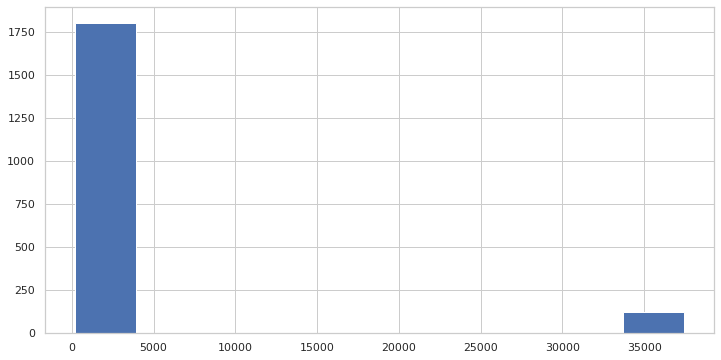

In [22]:
control_group.query('revenue > 0').revenue.hist()

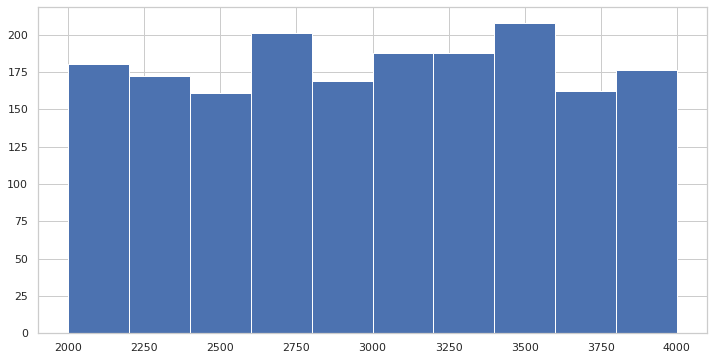

In [23]:
test_group.query('revenue > 0').revenue.hist()

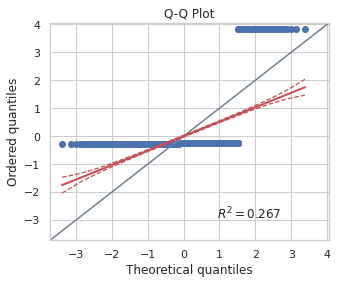

In [31]:
pg.qqplot(control_group.query('revenue > 0').revenue)

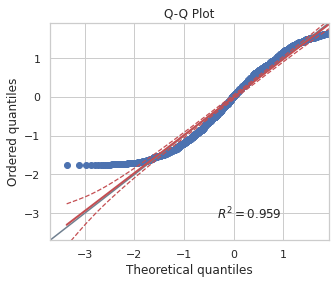

In [32]:
pg.qqplot(test_group.query('revenue > 0').revenue)

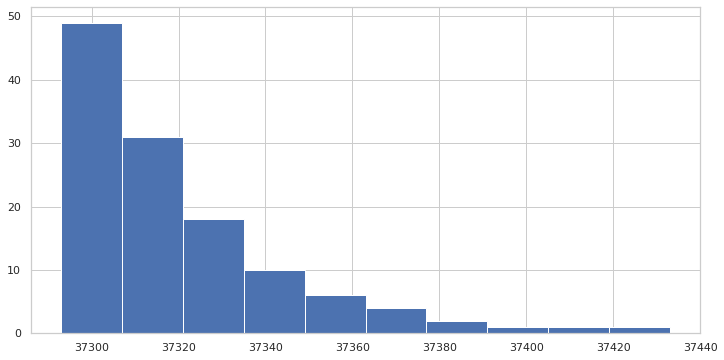

In [32]:
# В контрольной группе часть пользователей имеют аномально большой revenue, в то время как в тестовой группе
# покупки находятся в диапазоне 2000-4000. 
# Посмотрим на дорогостоящие покупки в контрольной группе

control_group.query('revenue > 30000').revenue.hist()

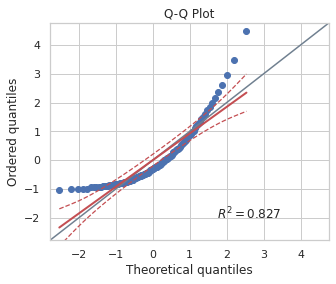

In [33]:
pg.qqplot(control_group.query('revenue > 30000').revenue)

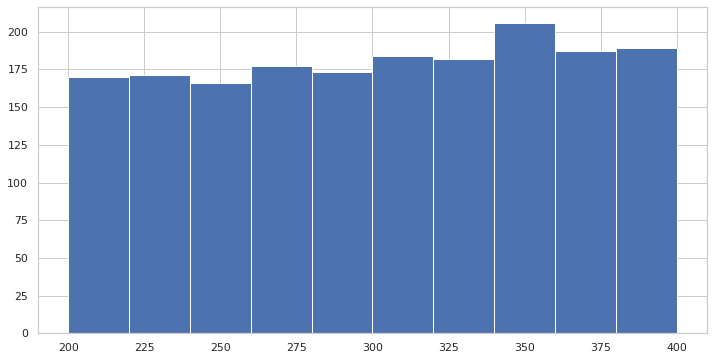

In [31]:
# Пробуем построить гистограмму без учета этих пользователей, видим что тогда покупки находятся в диапазоне 200-400

control_group.query('revenue > 0 & revenue < 30000').revenue.hist()

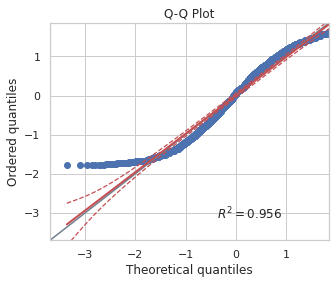

In [35]:
pg.qqplot(control_group.query('revenue > 0 & revenue < 30000').revenue)

In [38]:
# Посмотрим, какой процент от выручки в контрольной группе имеют клиенты с дорогостоящими покупками
round(control_group.query('revenue > 30000').revenue.sum()/control_group.revenue.sum(), 2) * 100

89.0

На этот раз я заметил, что в контрольной группе небольшая доля пользователей с дорогими покупками составляет 89% от общей выручки, в то время как остальные покупки находятся в диапазоне 200-400. В нашем случае нельзя с полной уверенностью утверждать, что это выбросы. В тестовой группе такого значительного преобладания дорогих покупок не наблюдается, и все они находятся в диапазоне 2000-4000. У меня возникают сомнения относительно корректности проведения A/B теста, так как в группах представлены разные, непересекающиеся сегменты пользователей: в контрольной группе — 200-400 и 37000+, а в тестовой — 2000-4000. Это может указывать на ошибку в сплитировании пользователей, и в таком случае стоит пересобрать группы и провести новый эксперимент.

Тем не менее, поскольку мы не знаем точного происхождения этих данных и какие товары участвовали в акции, а также учитывая, что в самом задании указано, что двум группам пользователей предлагались разные наборы акционных предложений, возможно, стоит сравнить акции для различных категорий товаров в обеих группах, которые принесли выручку на примерно одинаковом уровне. Тогда это может выглядить логично, и мы можем статистически сравнить наши метрики: CR, ARPU, ARPPU

Начнем с конверсии CR. 
Первая гипотеза для проверки:
- **Нулевая гипотеза (H0):** Не наблюдается значительных различий между платными и бесплатными пользователями в тестовой и контрольной группах.
- **Альтернативная гипотеза (H1):** Имеются значительные различия между платными и бесплатными пользователями в тестовой и контрольной группах.

In [39]:
# Группировка и подсчет значений плативших и неплативших пользователей для контрольной и тестовой группы
paid_vs_free_users = data.groupby('testgroup')['revenue'].agg(
    paid=lambda x: (x > 0).sum(),
    free=lambda x: (x <= 0).sum()
).reset_index()

In [40]:
paid_vs_free_users

,testgroup,paid,free
0,a,1928,200175
1,b,1805,200862


In [41]:
# Создание таблицы сопряженности
contingency_table = paid_vs_free_users[['paid', 'free']].values

In [46]:
# Проведение теста хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)

In [47]:
chi2, p

(4.374729521260405, 0.03647561892312613)

Полученное p-значение, которое составляет менее 0.05, дает нам возможность отвергнуть нулевую гипотезу и принять альтернативную. Это указывает на то, что конверсии в группах существенно различаются, и акции в контрольной группе более эффективно побуждают пользователей к совершению покупок.

Теперь проанализируем ARPPU.

Вторая гипотеза для проверки:
- **Нулевая гипотеза (H0):** Не наблюдается значительных различий ARPPU в тестовой и контрольной группах.
- **Альтернативная гипотеза (H1):** Имеются значительные различия ARPPU в тестовой и контрольной группах.

In [33]:
# Тест Левене для проверки гомогенности дисперсий
levene_test_arppu = stats.levene(control_group.query('revenue > 0').revenue, test_group.query('revenue > 0').revenue)

In [34]:
# Результаты теста Левене
print("Levene's test p-value:", levene_test_arppu.pvalue)

Levene's test p-value: 3.779689868667878e-19


In [35]:
# В зависимости от результата теста Левене
if levene_test_arppu.pvalue > 0.05:
    # Если p-value больше 0.05, мы принимаем гипотезу о равенстве дисперсий
    t_stat, p_value = stats.ttest_ind(control_group.query('revenue > 0').revenue, test_group.query('revenue > 0').revenue, equal_var=True)
else:
    # Если p-value меньше 0.05, дисперсии разные
    t_stat, p_value = stats.ttest_ind(control_group.query('revenue > 0').revenue, test_group.query('revenue > 0').revenue, equal_var=False)

print("P-value:", p_value)

P-value: 0.10020780398916015


Полученное p-значение > 0.05 не дает возможность отклонить нулевую гипотезу. Мы можем сделать вывод, что предложенные акции не оказали ожидаемого влияния на доход от платящих пользователей.

Теперь проанализируем ARPU.

Вторая гипотеза для проверки:
- **Нулевая гипотеза (H0):** Не наблюдается значительных различий ARPU в тестовой и контрольной группах.
- **Альтернативная гипотеза (H1):** Имеются значительные различия ARPU в тестовой и контрольной группах.

In [36]:
# Тест Левене для проверки гомогенности дисперсий
levene_test_arpu = stats.levene(control_group.revenue, test_group.revenue)

# Результаты теста Левене
print("Levene's test p-value:", levene_test_arpu.pvalue)

Levene's test p-value: 0.5324948591043842


In [37]:
# В зависимости от результата теста Левене
if levene_test_arpu.pvalue > 0.05:
    # Если p-value больше 0.05, мы принимаем гипотезу о равенстве дисперсий
    t_stat, p_value = stats.ttest_ind(control_group.revenue, test_group.revenue, equal_var=True)
else:
    # Если p-value меньше 0.05, дисперсии разные
    t_stat, p_value = stats.ttest_ind(control_group.revenue, test_group.revenue, equal_var=False)

print("P-value:", p_value)

P-value: 0.532494858971837


Полученное p-значение > 0.05 не дает возможность отклонить нулевую гипотезу. Мы можем сделать вывод, что предложенные акции не оказали ожидаемого влияния на доход на пользователя.

In [52]:
data.groupby('testgroup')['revenue'].sum()

testgroup
a    5136189
b    5421603
Name: revenue, dtype: int64

**Вывод:** Если все же считать, что A/B тест был проведен корректно, то после статистического анализа метрик можно сделать следующие выводы:
- Контрольная группа более эффективно побуждала пользователей к совершению покупок, однако при этом приносила меньшую прибыль по сравнению с тестовой группой. 
- Средний чек как для всех покупателей, так и для платящих пользователей статистически значимо не изменился. 

В результате нельзя однозначно определить, какая из групп показала лучшие результаты по акциям. В качестве решения можно рассмотреть возможность проведения повторного теста, с менее противоречивыми данными.

## Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?



Для оценки результатов последнего прошедшего события в игре Plants & Gardens можно выделить ключевые метрики, разделив их на три категории: **Эффективность завершения**, **Вовлеченность игроков** и **Сложность игрового процесса**. 

Метрики, которые могут быть добавлены после усложнения механики в новом событии, где игроки будут возвращаться на несколько уровней назад при каждой неудачной попытке, выделены зеленым цветом. 

Приоритизация метрик может выглядеть следующим образом:

### 1. Эффективность завершения
- **Процент завершения события:** Это основная метрика, отражающая, насколько многие игроки успешно справились с событием. 
- <span style="color:green">**Коэффициент завершения уровней:** Помогает оценить, насколько игроки могут преодолевать уровни после отката, что будет особенно важно при усложнении механик.</span>

### 2. Вовлеченность игроков
- **Время, проведенное в игре:** Общее время, проведенное игроками в игре в течение события, может показать интерес и вовлеченность в мероприятие.
- **Количество полученных наград:** Общее количество уникальных предметов и бонусов, полученных игроками в ходе события.
- **Общее количество собранных монет:** Сравнение количества монет, которые игроки собрали во время события, с предыдущими событиями.
- <span style="color:green">**Число возвратов пользователей в игру после неудачных попыток:** Показывает, насколько игроки мотивированы продолжать игру даже после трудностей.</span>

### 3. Сложность игрового процесса
- **Среднее время прохождения:** Время, затраченное игроками на прохождение уровня или всего события. Это поможет оценить, насколько сложно было пройти событие.
- <span style="color:green">**Среднее количество откатов:** Сколько раз в среднем игроки откатывались назад, что поможет оценить влияние сложности на игровой процесс.</span>
- <span style="color:green">**Время, проведенное на уровне:** Учитывая возможность откатов, эта метрика поможет понять, как долго игроки застревают на определенных этапах.</span>